In [28]:
import shutil
import os
from ray.rllib.algorithms.ddpg.ddpg import DDPGConfig
import ray
import gymnasium as gym
import tensorflow as tf
import numpy as np
import inspect
from tqdm import trange
import tensorflow_docs.vis.embed as embed

In [29]:
CHECKPOINT_ROOT = "tmp/ddpg/car_cont"
shutil.rmtree(CHECKPOINT_ROOT, ignore_errors=True, onerror=None)

ray_results = os.getenv("HOME") + "/ray_results/"
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

In [30]:
config = DDPGConfig().training(
    actor_hiddens=[32, 64],
    critic_hiddens=[64, 64],
    n_step=3,
    model={},
    gamma=0.99,
    target_network_update_freq=0,
    tau=0.01,
    replay_buffer_config=dict(
        type='MultiAgentPrioritizedReplayBuffer',
        capacity=50000,
        prioritized_replay_alpha=0.6,
        prioritized_replay_beta=0.4,
        prioritized_replay_eps=0.000001,
        worker_side_prioritization=False,
    ),
    num_steps_sampled_before_learning_starts=1000,
    actor_lr=0.001,
    critic_lr=0.001,
    use_huber=False,
    huber_threshold=1.0,
    l2_reg=0.00001,
    train_batch_size=64,
).exploration(
    exploration_config=dict(
        initial_scale=1.0,
        final_scale=0.02,
        scale_timesteps=40000,
        ou_base_scale=0.75,
        ou_theta=0.15,
        ou_sigma=0.2
    )
).reporting(
    min_sample_timesteps_per_iteration=1000
).environment(
    env='MountainCarContinuous-v0',
    clip_rewards=False
).rollouts(
    rollout_fragment_length=3,
).resources(num_gpus=1)
print(config.to_dict())
# Build a Trainer object from the config and run one training iteration.
algo = config.build()


{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 1, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': 'MountainCarContinuous-v0', 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': False, 'normalize_actions': True, 'clip_actions': False, 'disable_env_checking': False, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>, 'sample_async': False

In [34]:
N_ITER = 100
# s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} len {} saved {}"

t = trange(N_ITER)
for n in t:
    result = algo.train()
    file_name = algo.save(CHECKPOINT_ROOT)

    t.set_postfix(r_min=result["episode_reward_min"],
                 r_avg=result["episode_reward_mean"],
                 r_max=result["episode_reward_max"],
                 len=result["episode_len_mean"],
                 file=file_name)


100%|██████████| 100/100 [2:02:19<00:00, 73.40s/it, file=tmp/ddpg/car_cont/checkpoint_000200, len=999, r_avg=-.0828, r_max=-.0828, r_min=-.0829] 


In [32]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("MountainCarContinuous-v0", render_mode='rgb_array').env


def render_episode(env: gym.Env, algo: ray.rllib.algorithms.Algorithm, max_steps: int):
    state, info = env.reset()
    screen = env.render()
    images = [Image.fromarray(screen)]
    states = []
    actions = []

    for i in range(1, max_steps + 1):
        action = algo.compute_single_action(state)
        actions.append(action)

        state, reward, done, truncated, info = env.step(action)

        # Render screen every 10 steps
        if i % 10 == 0:
            screen = env.render()
            images.append(Image.fromarray(screen))

        if done:
            break

    return images, np.array(states), np.array(actions)


# Save GIF image
images, states, actions = render_episode(render_env, algo, 500)
image_file = 'MountainCarContinuous-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(image_file,
               save_all=True,
               append_images=images[1:],
               loop=0,
               duration=1)



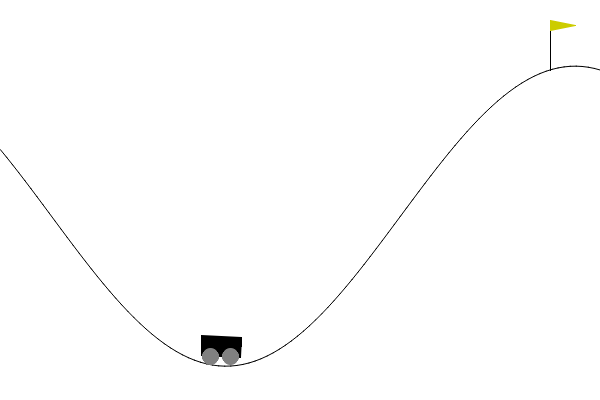

In [33]:
embed.embed_file(image_file)